# Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.manifold import TSNE

import networkx as nx

from IPython.display import display, HTML
tqdm.pandas()

# Load Data

In [2]:
pd_graph = pd.read_csv("data_tr.csv")
pd_graph

,u,v,t,h
0,8538,53245,82,9
1,32991,41149,39,4
2,30104,35030,25,4
3,26292,48613,37,1
4,31603,32991,59,9
...,...,...,...,...
48604,12751,71902,98,4
48605,6430,76576,89,6
48606,1021,6872,83,5
48607,28392,55610,75,8


In [3]:
nodes = sorted(list(set(pd_graph.v.append(pd_graph.u))))
num_nodes = len(nodes)
nodes

/tmp/ipykernel_6771/2328270939.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nodes = sorted(list(set(pd_graph.v.append(pd_graph.u))))


[2,
 19,
 22,
 25,
 26,
 29,
 31,
 33,
 38,
 40,
 46,
 50,
 51,
 55,
 67,
 72,
 76,
 79,
 88,
 95,
 96,
 117,
 122,
 125,
 127,
 128,
 140,
 141,
 144,
 158,
 162,
 186,
 191,
 195,
 220,
 221,
 230,
 234,
 236,
 238,
 241,
 242,
 244,
 245,
 249,
 252,
 254,
 263,
 268,
 276,
 284,
 287,
 290,
 293,
 294,
 305,
 313,
 315,
 316,
 318,
 328,
 331,
 332,
 340,
 341,
 358,
 365,
 368,
 373,
 374,
 378,
 379,
 383,
 390,
 391,
 392,
 395,
 399,
 413,
 417,
 418,
 419,
 423,
 428,
 432,
 437,
 439,
 445,
 461,
 462,
 464,
 468,
 472,
 480,
 482,
 487,
 503,
 518,
 525,
 527,
 535,
 541,
 563,
 571,
 576,
 589,
 592,
 594,
 605,
 607,
 610,
 623,
 628,
 638,
 647,
 655,
 658,
 671,
 677,
 678,
 695,
 709,
 714,
 719,
 720,
 782,
 790,
 799,
 800,
 806,
 822,
 823,
 837,
 845,
 847,
 865,
 866,
 869,
 872,
 878,
 939,
 942,
 945,
 954,
 957,
 972,
 979,
 990,
 1005,
 1014,
 1021,
 1022,
 1026,
 1030,
 1032,
 1036,
 1042,
 1043,
 1046,
 1053,
 1064,
 1065,
 1078,
 1086,
 1088,
 1089,
 1090,
 

# EDA

In [4]:
pd_graph.shape

(48609, 4)

In [5]:
pd_graph.u.value_counts()

32215    1099
4098      167
13815     128
22842     126
13190     107
         ... 
25800       1
14134       1
60229       1
24433       1
67920       1
Name: u, Length: 9300, dtype: int64

/tmp/ipykernel_6771/2752268001.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(src_degree[src_degree < 50])


<AxesSubplot: ylabel='Density'>

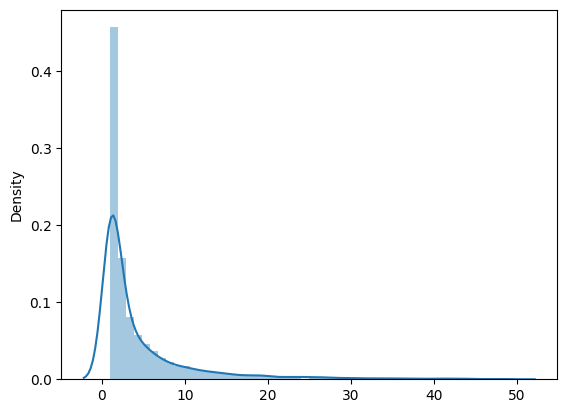

In [6]:
src_degree = np.array(list(pd_graph.u.value_counts()))
sns.distplot(src_degree[src_degree < 50])

In [7]:
pd_graph.v.value_counts()

32215    712
83552    140
80636    110
81115    106
76576     97
        ... 
29093      1
62930      1
6098       1
52621      1
6872       1
Name: v, Length: 9437, dtype: int64

/tmp/ipykernel_6771/794328783.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dst_degree[dst_degree < 50])


<AxesSubplot: ylabel='Density'>

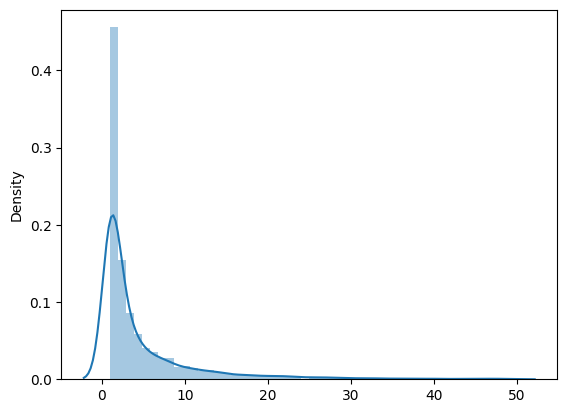

In [8]:
dst_degree = np.array(list(pd_graph.v.value_counts()))
sns.distplot(dst_degree[dst_degree < 50])

In [9]:
pd_graph.t.value_counts()

82    491
17    491
88    491
11    491
26    491
     ... 
18    491
81    491
79    491
19    491
33    491
Name: t, Length: 99, dtype: int64

In [10]:
pd_graph.h.value_counts()

2    4924
1    4923
3    4923
4    4922
0    4921
6    4917
5    4914
7    4895
8    4814
9    4456
Name: h, dtype: int64

/tmp/ipykernel_6771/1175231524.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=pd_graph.h, kde=False)


<AxesSubplot: >

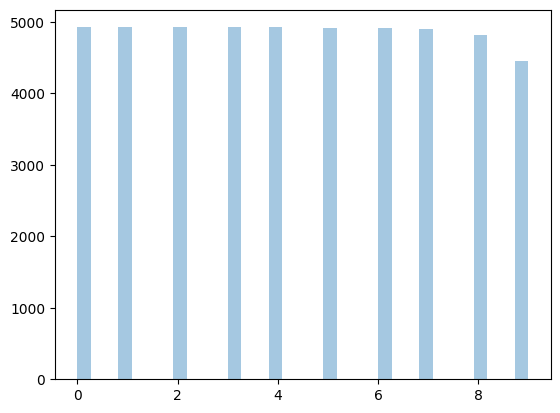

In [11]:
sns.distplot(x=pd_graph.h, kde=False)

<AxesSubplot: xlabel='h', ylabel='t'>

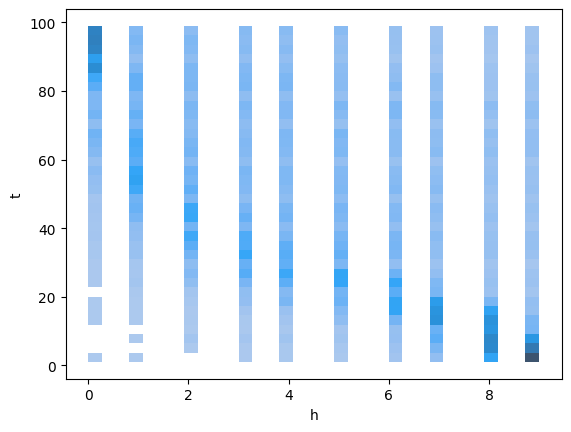

In [12]:
sns.histplot(pd_graph, x="h", y="t")

# ALS

In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(list(set(pd_graph.v.append(pd_graph.u))))

pd_graph.u = le.transform(pd_graph.u)
pd_graph.v = le.transform(pd_graph.v)
pd_graph

/tmp/ipykernel_6771/2056397769.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  le.fit(list(set(pd_graph.v.append(pd_graph.u))))


,u,v,t,h
0,1370,8415,82,9
1,5206,6477,39,4
2,4760,5521,25,4
3,4163,7660,37,1
4,5003,5206,59,9
...,...,...,...,...
48604,2028,11429,98,4
48605,1011,12176,89,6
48606,150,1069,83,5
48607,4496,8792,75,8


In [16]:
np_graph = pd_graph[["u", "v", "h"]].to_numpy()
np_graph

array([[1370, 8415,    9],
       [5206, 6477,    4],
       [4760, 5521,    4],
       ...,
       [ 150, 1069,    5],
       [4496, 8792,    8],
       [1011, 5098,    3]])

In [18]:
np_adj = np.zeros((num_nodes, num_nodes))
np_adj[np_graph[:, 0], np_graph[:, 1]] = np_graph[:, 2]
np_adj

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [23]:
import implicit
import scipy

model = implicit.als.AlternatingLeastSquares(factors=100)

model.fit(scipy.sparse.csr_matrix(np_adj))

  0%|          | 0/15 [00:00<?, ?it/s]

In [29]:
ids, dists = model.recommend(
    [i for i in range(num_nodes)], 
    scipy.sparse.csr_matrix(np_adj), 
    filter_already_liked_items=True,
    N=10
)
ids.shape

(13489, 10)

In [34]:
list_ids = list(ids)

for i in tqdm(range(num_nodes)):
    list_ids[i] = list(le.inverse_transform(list_ids[i]))

list_ids

100%|███████████████████████████████████| 13489/13489 [00:01<00:00, 8626.25it/s]


[[69367, 78981, 75981, 62818, 63272, 63507, 80949, 82823, 80636, 74299],
 [32215, 52391, 54990, 49064, 31389, 53433, 77906, 57087, 83041, 61312],
 [61857, 84641, 82993, 62825, 82577, 55291, 82880, 83542, 59331, 61350],
 [73853, 83040, 26913, 76813, 72635, 34579, 62509, 70796, 60343, 40746],
 [49829, 79887, 70071, 83080, 71616, 68819, 71484, 61550, 54094, 56688],
 [83552, 72130, 71608, 71882, 64344, 82453, 82577, 37181, 51301, 59251],
 [83552, 73514, 82453, 52921, 72302, 71882, 71478, 64925, 63571, 40746],
 [40, 38, 33, 31, 29, 26, 25, 22, 19, 2],
 [32215, 83552, 71882, 72130, 71608, 72302, 64344, 73514, 82577, 81744],
 [61904, 49064, 79389, 28686, 37181, 54467, 22602, 51628, 20791, 57087],
 [68727, 62054, 22326, 25384, 64397, 65974, 34363, 13933, 56419, 68843],
 [40, 38, 33, 31, 29, 26, 25, 22, 19, 2],
 [40, 38, 33, 31, 29, 26, 25, 22, 19, 2],
 [61857, 82993, 84641, 62825, 82577, 55291, 82880, 83542, 59331, 79847],
 [71810, 79938, 46895, 73763, 66719, 43596, 54990, 60441, 77906, 61856]

In [36]:
user_ids = le.inverse_transform([i for i in range(num_nodes)])
user_ids

array([    2,    19,    22, ..., 84723, 84731, 84739])

In [38]:
lines = [f"{user_ids[i]}: {','.join(list(map(str, list_ids[i])))}" for i in tqdm(range(num_nodes))]
lines


100%|█████████████████████████████████| 13489/13489 [00:00<00:00, 179566.66it/s]


['2: 69367,78981,75981,62818,63272,63507,80949,82823,80636,74299',
 '19: 32215,52391,54990,49064,31389,53433,77906,57087,83041,61312',
 '22: 61857,84641,82993,62825,82577,55291,82880,83542,59331,61350',
 '25: 73853,83040,26913,76813,72635,34579,62509,70796,60343,40746',
 '26: 49829,79887,70071,83080,71616,68819,71484,61550,54094,56688',
 '29: 83552,72130,71608,71882,64344,82453,82577,37181,51301,59251',
 '31: 83552,73514,82453,52921,72302,71882,71478,64925,63571,40746',
 '33: 40,38,33,31,29,26,25,22,19,2',
 '38: 32215,83552,71882,72130,71608,72302,64344,73514,82577,81744',
 '40: 61904,49064,79389,28686,37181,54467,22602,51628,20791,57087',
 '46: 68727,62054,22326,25384,64397,65974,34363,13933,56419,68843',
 '50: 40,38,33,31,29,26,25,22,19,2',
 '51: 40,38,33,31,29,26,25,22,19,2',
 '55: 61857,82993,84641,62825,82577,55291,82880,83542,59331,79847',
 '67: 71810,79938,46895,73763,66719,43596,54990,60441,77906,61856',
 '72: 63571,81115,54944,56239,31389,55291,40867,66582,39962,63720',
 '76: 

In [39]:
with open("als_preds.txt", "w") as fout:
    print("\n".join(lines), file=fout)